In [7]:
#Learning polys with different training sets

import rascal
from rascal.representations import SphericalInvariants as SOAP

import ase
from ase import io
#from ase import atoms

import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

import soprano
from soprano.properties.nmr import *

import random

import soprano
from soprano.properties.nmr import *

import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from numpy.linalg import lstsq

import pandas as pd

from pandas import DataFrame

In [4]:
def keys_grabber(category):
    keys = list(pickle.load(open('Data/' + category + '/uid_index.pkl','rb')).keys())
    for i in keys:
        if not os.path.exists('Data/'+category+'/' + str(i) + '.magres'):
            keys.remove(i)
    return keys

def descriptor(cut, smooth):
    HYPERS = {
    'soap_type': 'PowerSpectrum',
    'interaction_cutoff': cut,
    'max_radial': 2,
    'max_angular': 6,
    'gaussian_sigma_constant': 0.5,
    'gaussian_sigma_type': 'Constant',
    'cutoff_smooth_width': smooth,
    'radial_basis': 'GTO',
    'inversion_symmetry': True,
    'normalize' : True
    }
    soap = SOAP(**HYPERS)
    return soap


def puller(keys, soap, category):
    #reading in all structures and creating all spectrums.
    for i in keys:
        #print(i)
        if keys.index(i) == 0:
            structure = ase.io.read('Data/' + category +'/'+str(i)+'.magres')
            spectrum = soap.transform(structure).get_features(soap)
            full_spec = spectrum
            iso = MSIsotropy.get(structure)
        else:
            structure = ase.io.read('Data/' + category +'/'+str(i)+'.magres')
            spectrum = soap.transform(structure).get_features(soap)
            full_spec = np.concatenate((full_spec,spectrum),axis =0)
            iso = np.concatenate((iso,MSIsotropy.get(structure)),axis=0)
    return full_spec, iso


def splitter(tr_f, no_sparse, full_spec, iso):
    #Randomly choosing representative matrix
    ids = range(len(full_spec)) #list of all ids
    tr_id = random.sample(ids, int(tr_f*len(full_spec)))
    sp_id = random.sample(tr_id, no_sparse)

    tr_sp = full_spec[tr_id] #training spectrums
    sp_sp = full_spec[sp_id] #representative/sparse spectrums

    tr_ta = iso[tr_id] #training target
    
    te_id = list(ids)
    for i in tr_id:
        te_id.remove(i)
    te_sp = full_spec[te_id]
    te_ta = iso[te_id]
    
    return sp_sp, tr_sp, tr_ta, te_sp, te_ta 
    
    
def kerneller(to_kernel, sp_sp, ker_exp):
    kernel = (to_kernel@sp_sp.T)**ker_exp
    return kernel

In [10]:
def model_maker(cat, cut, smo_cut, sp_size, ker_exp, reg):
    for i in cat:
        if cat.index(i) == 0:
            keys = keys_grabber(i)
            soap = descriptor(cut, smo_cut)
            full_spec, iso = puller(keys, soap, i)
        else:
            keys = keys_grabber(i)
            soap = descriptor(cut, smo_cut)
            full_spec_t, iso_t = puller(keys, soap, i)
            full_spec = np.concatenate((full_spec, full_spec_t))
            iso = np.concatenate((iso, iso_t))
    sp_sp, tr_sp, tr_ta, te_sp, te_ta = splitter(1, sp_size, full_spec, iso)
    
    KNM = kerneller(tr_sp, sp_sp, ker_exp)
    KMM = kerneller(sp_sp, sp_sp, ker_exp)
    res = lstsq(KNM.T @ KNM + reg * KMM, KNM.T @ tr_ta, rcond=None)
    c = res[0]
    
    return c, sp_sp

def predictor(cat, cut, smo_cut, ker_exp, reg, c, sp_sp):
#     keys = keys_grabber(cat)
    keys = [13]
    soap = descriptor(cut, smo_cut)
    full_spec, iso = puller(keys, soap, cat)
    KTM = kerneller(full_spec, sp_sp, ker_exp)
    pred = KTM @ c
    rmse = mean_squared_error(iso, pred, squared=False)
    return iso, pred, rmse

def species_splitter(target, predicted):
    ids_o = []
    ids_si = []

    for i in enumerate(target):
        if i[1] < 350:
            ids_o.append(i[0])
        else:
            ids_si.append(i[0])
            
    o_tar = target[ids_o]
    o_pred = predicted[ids_o]
    
    si_tar = target[ids_si]
    si_pred = predicted[ids_si]
    
    return o_tar, si_tar, o_pred, si_pred
    

In [11]:
#Params - nowusing same for all
cut = 3.5
smo_cut = 1
sp_size = 1000
ker_exp = 25
reg = 1*10**-8

In [117]:
c, sp_sp = model_maker(['HypoZeo'],cut,smo_cut, sp_size, ker_exp,reg)
tar, pred_r, rmse = predictor('Polymorphs', cut, smo_cut, ker_exp, reg, c, sp_sp)
o_tar_r, si_tar_r, o_pred_r, si_pred_r = species_splitter(tar, pred_r)
print(rmse)

5.334089107518412


In [111]:
df=pd.DataFrame()
df['DFT'] = si_tar_r
df['Rattle + HypoZeo'] = si_pred_r

In [121]:
df.to_csv('NMR_spectra_data.csv')
df.head()

,DFT,Rattle + HypoZeo,Rattle,HypoZeo
0,446.326505,446.532643,446.263127,443.069143
1,446.326505,446.532643,446.263127,443.069143
2,447.555825,447.837686,447.999331,444.252621
3,441.346992,441.615685,441.102705,441.274924
4,441.346992,441.615685,441.102705,441.274924


In [97]:
data = np.unique(np.around(np.sort(si_tar_r),2), return_counts=True)
data_occ = data[1]/np.ndarray.max(data[1])
sigma_ref = np.mean([-111.9,-112.3,-116.2,-116.5,-117.2] + data[0])
data_dat = sigma_ref - data[0]
data_tup = zip(data_occ, data_dat)

(-109.0, -120.0)

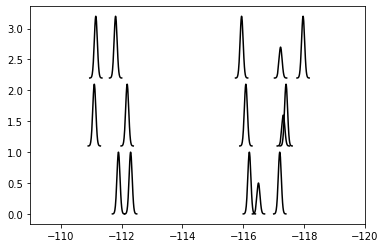

In [108]:
from scipy.stats import norm

def gauss_plotter(center, height):
    x = np.linspace(center-0.2,center+0.2,1000)
    y = norm.pdf(x,center,0.05)
    y = y/np.ndarray.max(y)*height
    return x, y

def data_generator(data):
    data = np.unique(np.around(np.sort(data),2), return_counts=True)
    data_occ = data[1]/np.ndarray.max(data[1])
    sigma_ref = np.mean([-111.9,-112.3,-116.2,-116.5,-117.2] + data[0])
    data_dat = sigma_ref - data[0]
    data_tup = zip(data_occ, data_dat)
    return data_tup
    

exp_dat = [-111.9,-112.3,-116.2,-116.5,-117.2]
exp_occ = [1,1,1,0.5,1]
exp_tup = zip(exp_occ, exp_dat)

for i in exp_tup:
    x,y = gauss_plotter(i[1],i[0])
    plt.plot(x,y, color='black')

for i in data_generator(si_tar_r):
    x,y = gauss_plotter(i[1],i[0])
    plt.plot(x,y+1.1, color='black')
    
for i in data_generator(si_pred_r):
    x,y = gauss_plotter(i[1],i[0])
    plt.plot(x,y+2.2, color='black')
    
plt.xlim(-109,-120)
# plt.ylim(0,1.3)
# plt.yticks([])


In [73]:
y

array([0.13533555, 0.13642258, 0.13751613, 0.13861623, 0.13972288,
       0.14083612, 0.14195594, 0.14308238, 0.14421544, 0.14535515,
       0.14650151, 0.14765455, 0.14881428, 0.14998071, 0.15115386,
       0.15233374, 0.15352038, 0.15471377, 0.15591395, 0.15712091,
       0.15833468, 0.15955527, 0.16078269, 0.16201696, 0.16325808,
       0.16450607, 0.16576094, 0.16702271, 0.16829139, 0.16956698,
       0.17084951, 0.17213897, 0.17343539, 0.17473877, 0.17604912,
       0.17736645, 0.17869078, 0.1800221 , 0.18136044, 0.1827058 ,
       0.18405819, 0.18541762, 0.18678409, 0.18815762, 0.1895382 ,
       0.19092586, 0.19232059, 0.19372241, 0.19513132, 0.19654732,
       0.19797042, 0.19940063, 0.20083795, 0.20228239, 0.20373395,
       0.20519264, 0.20665846, 0.20813141, 0.20961151, 0.21109874,
       0.21259311, 0.21409464, 0.21560331, 0.21711913, 0.2186421 ,
       0.22017223, 0.22170951, 0.22325394, 0.22480553, 0.22636428,
       0.22793017, 0.22950322, 0.23108342, 0.23267078, 0.23426

In [43]:
df = pd.DataFrame()
df['target'] = tar
df['predicted'] = pred_r
df.to_csv('Rattle_Plus_HypoZeo_wrt_poly_raw.csv')

In [38]:
import itertools
cats = ['Rattle', 'HypoZeo', 'AM0K', 'AM300K', 'MD_Distorted']
combos = list(itertools.combinations(cats,2))
over_mas = []
si_mas = []
o_mas = []


for i in combos:
    i = list(i)
    over = []
    si = []
    o = []

    counter = 0
    while counter < 10:

        c, sp_sp = model_maker(i,cut,smo_cut, sp_size, ker_exp,reg)
        tar, pred_r, rmse = predictor('Polymorphs', cut, smo_cut, ker_exp, reg, c, sp_sp)
        o_tar_r, si_tar_r, o_pred_r, si_pred_r = species_splitter(tar, pred_r)
        si.append(mean_squared_error(si_tar_r, si_pred_r, squared=False))
        o.append(mean_squared_error(o_tar_r, o_pred_r, squared=False))
        over.append(rmse)

        print(counter)
        print(rmse)
        counter += 1

    print('Overall error = ' + str(sum(over)/len(over)))
    print('Si Error = ' + str(sum(si)/len(si)))
    print('O Error = ' + str(sum(o)/len(o)))
    
    over_mas.append(sum(over)/len(over))
    si_mas.append(sum(si)/len(si))
    o_mas.append(sum(o)/len(o))
    

0
3.1628411168522588
1
3.4343169054698985
2
3.1184472066191304
3
3.263425932826579
4
2.874815378412984
5
3.4754731155462526
6
3.076881534108162
7
2.9599719234536854
8
3.063790685213943
9
2.8612078488192365
Overall error = 3.129117164732213
Si Error = 0.965619500660123
O Error = 3.7699185081529065
0
3.8770110836088647
1
3.135421063398818
2
3.445327423300327
3
3.3724400977283833
4
2.9781652743926963
5
3.0724179593506995
6
3.1436607118686086
7
2.99668776471805
8
3.7799645927259675
9
3.061488111633503
Overall error = 3.286258408272592
Si Error = 0.8974246762626225
O Error = 3.9731830517166555
0
3.1806933655553618
1
2.9048817824419517
2
3.117567648749317
3
3.0978299352929173
4
3.17884657774079
5
2.7752605532166674
6
3.330162686008877
7
2.9559172086632457
8
2.845803751830204
9
3.165856942601416
Overall error = 3.055282045210075
Si Error = 1.1150034201906798
O Error = 3.656440777631237
0
3.869917965369576
1
3.476130435802202
2
3.7745755196913082
3
3.568258965555949
4
3.356354821576243
5
3.666

In [40]:
df = pd.DataFrame()
df['combos'] = combos
df['overall error'] = over_mas
df['Si error'] = si_mas
df['O error'] = o_mas
df.head(10)
df.to_csv('Learning_Poly_pairs_master.csv')

In [5]:
#Rattle
c, sp_sp = model_maker(['Rattle'],cut,smo_cut, sp_size, ker_exp,reg)
tar, pred_r, rmse = predictor('Polymorphs', cut, smo_cut, ker_exp, reg, c, sp_sp)
o_tar_r, si_tar_r, o_pred_r, si_pred_r = species_splitter(tar, pred_r)

In [11]:
df1 = pd.DataFrame()
df1['O tar'] = o_tar_r
df1['O pred'] = o_pred_r
df1.to_csv('Rattle_O_wrt_poly.csv')
df2 = pd.DataFrame()
df2['Si tar'] = si_tar_r
df2['Si pred'] = si_pred_r
df2.to_csv('Rattle_Si_wrt_poly.csv')

Text(0.5, 1.0, 'Rattle')

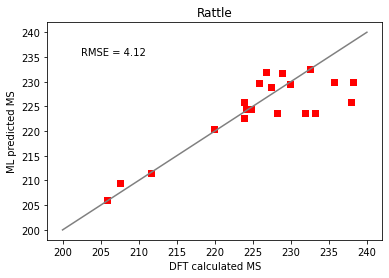

In [76]:
#O Rattle plot
plt.plot([200,240],[200,240], color='grey', linestyle='-')
plt.scatter(o_tar_r, o_pred_r, marker='s', color='red')
rmse = round(mean_squared_error(o_tar_r, o_pred_r, squared=False),2)
plt.xlabel('DFT calculated MS')
plt.ylabel('ML predicted MS')
plt.annotate('RMSE = ' + str(rmse), xycoords='axes fraction', xy=(0.1,0.85))
plt.title('Rattle')

Text(0.5, 1.0, 'Rattle')

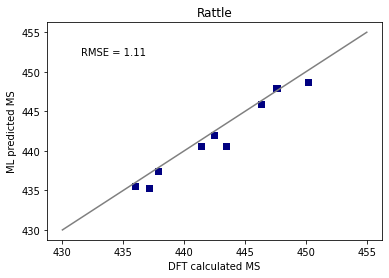

In [77]:
#Si Rattle plot
plt.scatter(si_tar_r, si_pred_r , marker='s', color='navy')
plt.plot([430,455], [430,455], color='grey', linestyle='-')
rmse = round(mean_squared_error(si_tar_r, si_pred_r, squared=False),2)
plt.xlabel('DFT calculated MS')
plt.ylabel('ML predicted MS')
plt.annotate('RMSE = ' + str(rmse), xycoords='axes fraction', xy=(0.1,0.85))
plt.title('Rattle')

In [7]:
#HypoZeo
c, sp_sp = model_maker(['HypoZeo'],cut,smo_cut, sp_size, ker_exp,reg)
tar, pred_r, rmse = predictor('Polymorphs', cut, smo_cut, ker_exp, reg, c, sp_sp)
o_tar_h, si_tar_h, o_pred_h, si_pred_h = species_splitter(tar, pred_r)

In [8]:
df1 = pd.DataFrame()
df1['O tar'] = o_tar_h
df1['O pred'] = o_pred_h
df1.to_csv('HypoZeo_O_wrt_poly.csv')
df2 = pd.DataFrame()
df2['Si tar'] = si_tar_h
df2['Si pred'] = si_pred_h
df2.to_csv('HypoZeo_Si_wrt_poly.csv')

Text(0.5, 1.0, 'Hypothetical Zeolite')

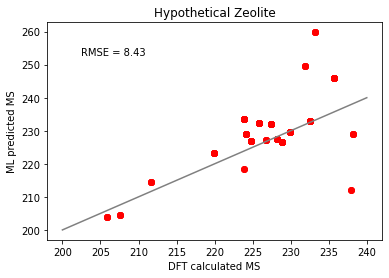

In [9]:
#O HypoZeo plot
plt.scatter(o_tar_h, o_pred_h, marker='o', color='red')
plt.plot([200,240],[200,240], color='grey', linestyle='-')
rmse = round(mean_squared_error(o_tar_h, o_pred_h, squared=False),2)
plt.xlabel('DFT calculated MS')
plt.ylabel('ML predicted MS')
plt.annotate('RMSE = ' + str(rmse), xycoords='axes fraction', xy=(0.1,0.85))
plt.title('Hypothetical Zeolite')

Text(0.5, 1.0, 'Hypothetical Zeolite')

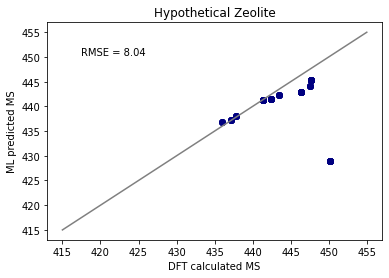

In [80]:
#Si HypoZeo plot
plt.scatter(si_tar_h, si_pred_h, marker='o', color='navy')
plt.plot([415,455], [415,455], color='grey', linestyle='-')
rmse = round(mean_squared_error(si_tar_h, si_pred_h, squared=False),2)
plt.xlabel('DFT calculated MS')
plt.ylabel('ML predicted MS')
plt.annotate('RMSE = ' + str(rmse), xycoords='axes fraction', xy=(0.1,0.85))
plt.title('Hypothetical Zeolite')

In [10]:
#AM0
c, sp_sp = model_maker(['AM0K'],cut,smo_cut, sp_size, ker_exp,reg)
tar, pred_r, rmse = predictor('Polymorphs', cut, smo_cut, ker_exp, reg, c, sp_sp)
o_tar_a0, si_tar_a0, o_pred_a0, si_pred_a0 = species_splitter(tar, pred_r)

In [13]:
df1 = pd.DataFrame()
df1['O tar'] = o_tar_a0
df1['O pred'] = o_pred_a0
df1.to_csv('AM0K_O_wrt_poly.csv')
df2 = pd.DataFrame()
df2['Si tar'] = si_tar_a0
df2['Si pred'] = si_pred_a0
df2.to_csv('AM0K_Si_wrt_poly.csv')

Text(0.5, 1.0, 'AM0K')

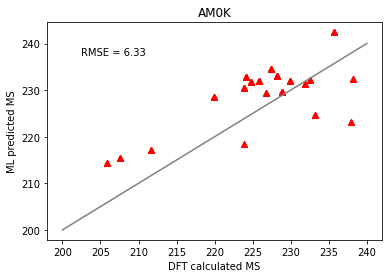

In [82]:
#O AM0K
plt.scatter(o_tar_a0, o_pred_a0, marker='^', color='red')
plt.plot([200,240],[200,240], color='grey', linestyle='-')
rmse = round(mean_squared_error(o_tar_a0, o_pred_a0, squared=False),2)
plt.xlabel('DFT calculated MS')
plt.ylabel('ML predicted MS')
plt.annotate('RMSE = ' + str(rmse), xycoords='axes fraction', xy=(0.1,0.85))
plt.title('AM0K')

Text(0.5, 1.0, 'AM0K')

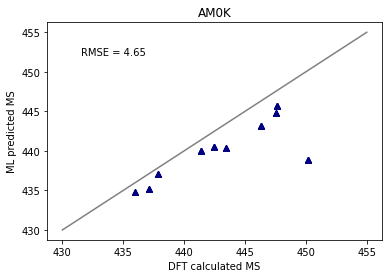

In [83]:
#Si AM0K
plt.scatter(si_tar_a0, si_pred_a0, marker='^', color='navy')
plt.plot([430,455], [430,455], color='grey', linestyle='-')
rmse = round(mean_squared_error(si_tar_a0, si_pred_a0, squared=False),2)
plt.xlabel('DFT calculated MS')
plt.ylabel('ML predicted MS')
plt.annotate('RMSE = ' + str(rmse), xycoords='axes fraction', xy=(0.1,0.85))
plt.title('AM0K')

In [14]:
#AM300K
c, sp_sp = model_maker(['AM300K'],cut,smo_cut, sp_size, ker_exp,reg)
tar, pred_r, rmse = predictor('Polymorphs', cut, smo_cut, ker_exp, reg, c, sp_sp)
o_tar_a3, si_tar_a3, o_pred_a3, si_pred_a3 = species_splitter(tar, pred_r)

In [16]:
df1 = pd.DataFrame()
df1['O tar'] = o_tar_a3
df1['O pred'] = o_pred_a3
df1.to_csv('AM3K_O_wrt_poly.csv')
df2 = pd.DataFrame()
df2['Si tar'] = si_tar_a3
df2['Si pred'] = si_pred_a3
df2.to_csv('AM3K_Si_wrt_poly.csv')

Text(0.5, 1.0, 'AM300K')

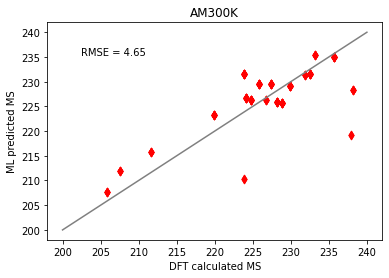

In [85]:
#O AM300K
plt.scatter(o_tar_a3, o_pred_a3, marker='d', color='red')
plt.plot([200,240],[200,240], color='grey', linestyle='-')
rmse = round(mean_squared_error(o_tar_a3, o_pred_a3, squared=False),2)
plt.xlabel('DFT calculated MS')
plt.ylabel('ML predicted MS')
plt.annotate('RMSE = ' + str(rmse), xycoords='axes fraction', xy=(0.1,0.85))
plt.title('AM300K')

Text(0.5, 1.0, 'AM300K')

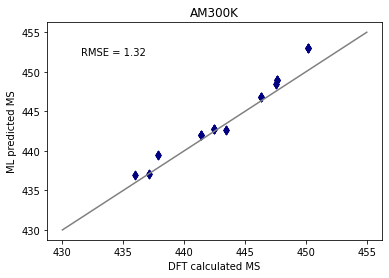

In [86]:
#Si AM300K
plt.scatter(si_tar_a3, si_pred_a3, marker='d', color='navy')
plt.plot([430,455], [430,455], color='grey', linestyle='-')
rmse = round(mean_squared_error(si_tar_a3, si_pred_a3, squared=False),2)
plt.xlabel('DFT calculated MS')
plt.ylabel('ML predicted MS')
plt.annotate('RMSE = ' + str(rmse), xycoords='axes fraction', xy=(0.1,0.85))
plt.title('AM300K')

In [17]:
#MD-disorted
c, sp_sp = model_maker(['AM300K'],cut,smo_cut, sp_size, ker_exp,reg)
tar, pred_r, rmse = predictor('Polymorphs', cut, smo_cut, ker_exp, reg, c, sp_sp)
o_tar_m, si_tar_m, o_pred_m, si_pred_m = species_splitter(tar, pred_r)

In [18]:
df1 = pd.DataFrame()
df1['O tar'] = o_tar_m
df1['O pred'] = o_pred_m
df1.to_csv('MD_O_wrt_poly.csv')
df2 = pd.DataFrame()
df2['Si tar'] = si_tar_m
df2['Si pred'] = si_pred_m
df2.to_csv('MD_Si_wrt_poly.csv')

Text(0.5, 1.0, 'MD')

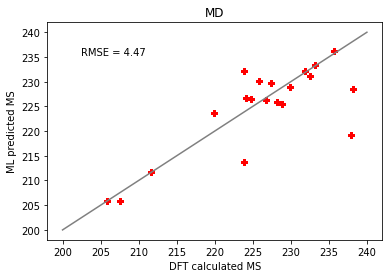

In [88]:
#O MD_Distorted
plt.scatter(o_tar_m, o_pred_m, marker='P', color='red')
plt.plot([200,240],[200,240], color='grey', linestyle='-')
rmse = round(mean_squared_error(o_tar_m, o_pred_m, squared=False),2)
plt.xlabel('DFT calculated MS')
plt.ylabel('ML predicted MS')
plt.annotate('RMSE = ' + str(rmse), xycoords='axes fraction', xy=(0.1,0.85))
plt.title('MD')

Text(0.5, 1.0, 'MD')

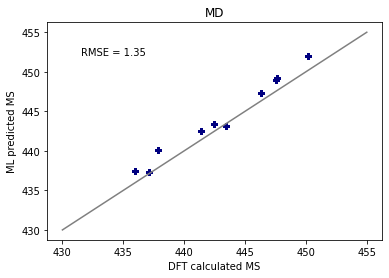

In [89]:
#Si MD_Distorted
plt.scatter(si_tar_m, si_pred_m, marker='P', color='navy')
plt.plot([430,455], [430,455], color='grey', linestyle='-')
rmse = round(mean_squared_error(si_tar_m, si_pred_m, squared=False),2)
plt.xlabel('DFT calculated MS')
plt.ylabel('ML predicted MS')
plt.annotate('RMSE = ' + str(rmse), xycoords='axes fraction', xy=(0.1,0.85))
plt.title('MD')

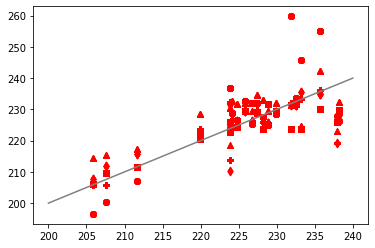

In [90]:
#Plot all O
color = 'red'
plt.plot([200,240],[200,240], color='grey', linestyle='-')
plt.scatter(o_tar_r, o_pred_r, marker='s', color=color) #Rattle
plt.scatter(o_tar_h, o_pred_h, marker='o', color=color) #HypoZeo
plt.scatter(o_tar_a0, o_pred_a0, marker='^', color=color) #AM0
plt.scatter(o_tar_a3, o_pred_a3, marker='d', color=color) #AM3
plt.scatter(o_tar_m, o_pred_m, marker='P', color=color) #MD



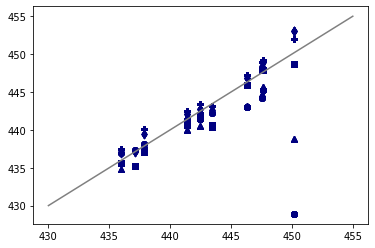

In [93]:
#Plot all Si
color = 'navy'
plt.plot([430,455], [430,455], color='grey', linestyle='-')
plt.scatter(si_tar_r, si_pred_r, marker='s', color=color, label='Rattle') #Rattle
plt.scatter(si_tar_h, si_pred_h, marker='o', color=color, label='HypoZeo') #HypoZeo
plt.scatter(si_tar_a0, si_pred_a0, marker='^', color=color) #AM0
plt.scatter(si_tar_a3, si_pred_a3, marker='d', color=color) #AM3
plt.scatter(si_tar_m, si_pred_m, marker='P', color=color) #MD


In [4]:
df = pd.read_csv('learn_polys_singlesets_rmse.csv')
df.head()

,Unnamed: 0,Combos,O Error,Si Error
0,0,Rattle,4.132,1.162
1,1,HypoZeo,9.299,8.146
2,2,AM0K,6.416,1.880
3,3,AM300K,4.763,1.074
4,4,MD_Distorted,6.539,1.114


Text(0.5, 1.0, 'Error for learning Polys')

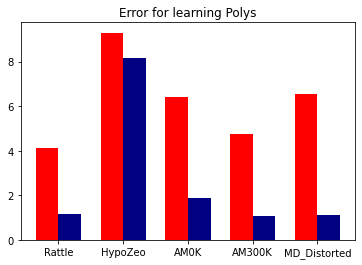

In [9]:
width = 0.35
x = np.arange(1,len(df['Combos'])+1)

ax = plt.subplot()
ax.bar(x-width/2,df['O Error'], width=width, color = 'red')
ax.bar(x+width/2,df['Si Error'], width=width, color = 'navy')
ax.set_xticks(x)
ax.set_xticklabels(df['Combos'])
#plt.xticks(rotation=90)
plt.title('Error for learning Polys')